# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейронную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [23]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [25]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0

    # Subtract mean
    mean_image = np.mean(train_flat, axis=0)
    train_flat -= mean_image
    test_flat -= mean_image

    return train_flat, test_flat


train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val=1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [26]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1, -2, 3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [27]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [28]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=3, reg=0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for layer_1_W
Gradient check passed!
Checking gradient for layer_1_B
Gradient check passed!
Checking gradient for layer_2_W
Gradient check passed!
Checking gradient for layer_2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [29]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=3, reg=1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg,
                                               loss), "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (
    loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for layer_1_W
Gradient check passed!
Checking gradient for layer_1_B
Gradient check passed!
Checking gradient for layer_2_W
Gradient check passed!
Checking gradient for layer_2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [30]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30])

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [31]:
model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.217215, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.155566, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.101459, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.286570, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.170695, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.067441, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.367471, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.110023, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.226594, Train accuracy: 0.207667, val accuracy: 0.215000
Loss: 2.068688, Train accuracy: 0.230111, val accuracy: 0.235000
Loss: 2.120957, Train accuracy: 0.256444, val accuracy: 0.258000
Loss: 2.110639, Train accuracy: 0.268778, val accuracy: 0.268000
Loss: 2.121036, Train accuracy: 0.282556, val accuracy: 0.287000
Loss: 1.999364, Train accuracy: 0.300111, val accuracy: 0.306000
Loss: 2.058220, Train accuracy: 0.322222, val accuracy: 0.325000
Loss: 1.853882, Train acc

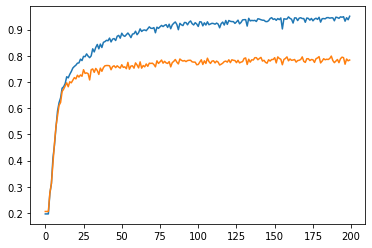

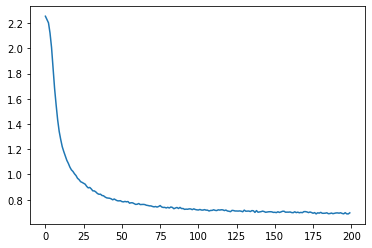

In [47]:
plt.plot(train_history)
plt.plot(val_history)
plt.show()
plt.plot(loss_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [33]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99, num_epochs=50, learning_rate=1e-2)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5 * initial_learning_rate, "Learning rate shouldn't have been reduced that much!"

Loss: 2.246074, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.372562, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.209350, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.260245, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.182553, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.195048, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.086410, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.321902, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.248486, Train accuracy: 0.200889, val accuracy: 0.210000
Loss: 2.193291, Train accuracy: 0.225889, val accuracy: 0.230000
Loss: 2.084251, Train accuracy: 0.241111, val accuracy: 0.242000
Loss: 2.093536, Train accuracy: 0.268000, val accuracy: 0.267000
Loss: 2.380028, Train accuracy: 0.276667, val accuracy: 0.271000
Loss: 1.764889, Train accuracy: 0.280556, val accuracy: 0.286000
Loss: 2.301798, Train accuracy: 0.299778, val accuracy: 0.306000
Loss: 1.942206, Train acc

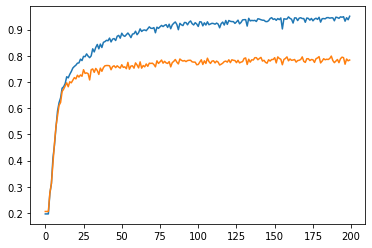

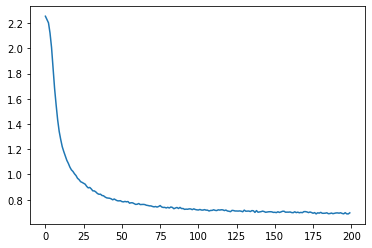

In [46]:
plt.plot(train_history)
plt.plot(val_history)
plt.show()
plt.plot(loss_history)

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:
http://cs231n.github.io/neural-networks-3/#sgd
https://distill.pub/2017/momentum/

In [35]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.042450, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.016390, Train accuracy: 0.390000, val accuracy: 0.383000
Loss: 1.284857, Train accuracy: 0.532333, val accuracy: 0.523000
Loss: 1.277686, Train accuracy: 0.646556, val accuracy: 0.635000
Loss: 1.075218, Train accuracy: 0.673111, val accuracy: 0.663000
Loss: 1.475674, Train accuracy: 0.687444, val accuracy: 0.670000
Loss: 1.319550, Train accuracy: 0.719111, val accuracy: 0.690000
Loss: 1.195417, Train accuracy: 0.690000, val accuracy: 0.665000
Loss: 0.903872, Train accuracy: 0.730667, val accuracy: 0.690000
Loss: 0.910427, Train accuracy: 0.728000, val accuracy: 0.675000
Loss: 1.218858, Train accuracy: 0.757444, val accuracy: 0.697000
Loss: 0.900639, Train accuracy: 0.765111, val accuracy: 0.727000
Loss: 1.034137, Train accuracy: 0.754222, val accuracy: 0.697000
Loss: 0.898191, Train accuracy: 0.766556, val accuracy: 0.711000
Loss: 0.890625, Train accuracy: 0.807889, val accuracy: 0.741000
Loss: 1.148567, Train acc

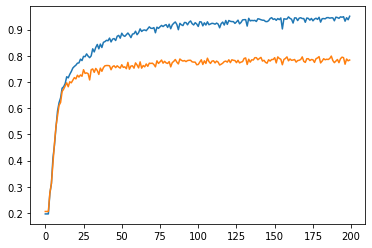

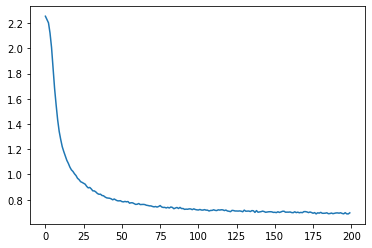

In [45]:
plt.plot(train_history)
plt.plot(val_history)
plt.show()
plt.plot(loss_history)

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (over-fit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [37]:
data_size = 15
model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.339830, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.312190, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.284686, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.268495, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.328550, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.284221, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.298779, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.227951, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.156622, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.012343, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.902222, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.766405, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.231698, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.955407, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.195686, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.935850, Train acc

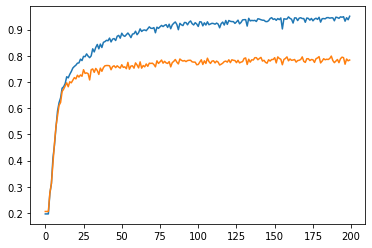

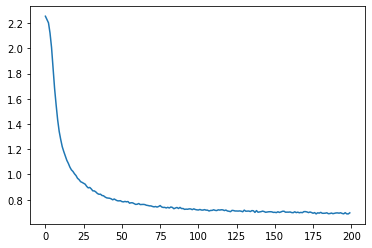

In [44]:
plt.plot(train_history)
plt.plot(val_history)
plt.show()
plt.plot(loss_history)

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

Loss: 2.336164, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 2.097298, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 5.414623, Train accuracy: 0.133333, val accuracy: 0.066667
Loss: 0.632005, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.764083, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 4.990455, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 1.914875, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 1.177535, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.556460, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 4.393352, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 7.519626, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 45.202966, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.105068, Train accuracy: 0.600000, val accuracy: 0.066667
Loss: 0.017709, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 0.172181, Train accuracy: 0.600000, val accuracy: 0.066667
Loss: 0.023850, Train ac

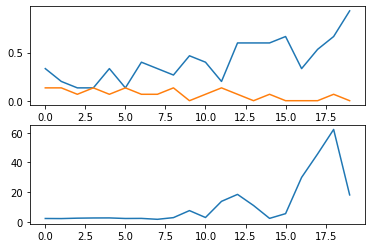

In [39]:
# Now, tweak some hyperparameters and make it train to 1.0 accuracy in 20 epochs or fewer

model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=200, reg=1e-4)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparameters or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1 + 0.05, num_epochs=20, batch_size=2,
                  learning_rate_decay=0.999)

loss_history, train_history, val_history = trainer.fit()
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(train_history)
plt.plot(val_history)
plt.subplot(2, 1, 2)
plt.plot(loss_history)

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [40]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-2
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

dataset = Dataset(train_X, train_y, val_X, val_y)

model = TwoLayerNet(n_input=train_X.shape[1], n_output=10,
                    hidden_layer_size=hidden_layer_size,
                    reg=reg_strength)

trainer = Trainer(model, dataset, MomentumSGD(),
                  num_epochs=num_epochs,
                  batch_size=batch_size,
                  learning_rate=learning_rates,
                  learning_rate_decay=learning_rate_decay)

loss_history, train_history, val_history = trainer.fit()
best_val_accuracy = max(val_history)
print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 2.201111, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.280905, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.103198, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 1.919205, Train accuracy: 0.275111, val accuracy: 0.277000
Loss: 1.795937, Train accuracy: 0.312333, val accuracy: 0.313000
Loss: 1.764967, Train accuracy: 0.409556, val accuracy: 0.389000
Loss: 1.846176, Train accuracy: 0.459000, val accuracy: 0.466000
Loss: 1.333257, Train accuracy: 0.527778, val accuracy: 0.531000
Loss: 1.376816, Train accuracy: 0.589333, val accuracy: 0.572000
Loss: 1.211872, Train accuracy: 0.621222, val accuracy: 0.611000
Loss: 1.111433, Train accuracy: 0.639667, val accuracy: 0.622000
Loss: 1.015440, Train accuracy: 0.676556, val accuracy: 0.664000
Loss: 1.183038, Train accuracy: 0.681889, val accuracy: 0.673000
Loss: 1.030546, Train accuracy: 0.694222, val accuracy: 0.685000
Loss: 1.069911, Train accuracy: 0.720222, val accuracy: 0.697000
Loss: 1.018723, Train acc

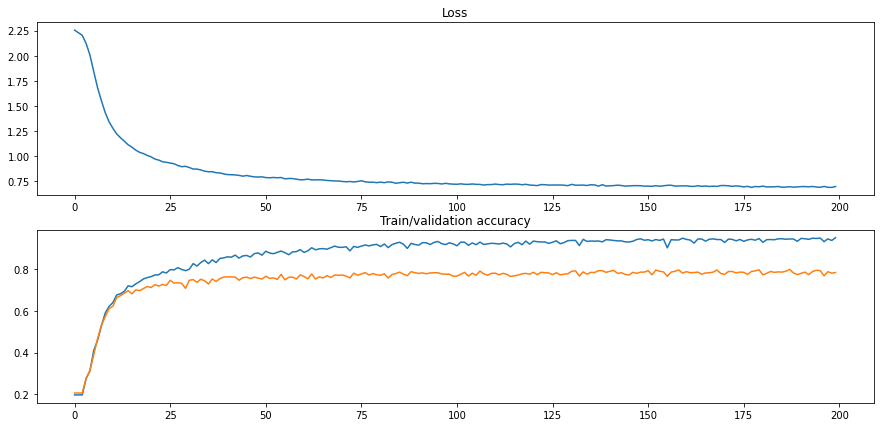

In [41]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных


In [43]:
test_pred = model.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy,))

Neural net test set accuracy: 0.770000
